# Clustering for RDD

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sys import path
path.append("..")

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdd import measures
from rdd import RDD
from rdd.RDD import get_rdd_matrix
from rdd import visualize
from rdd import other_sims
from rdd import ascos
from rdd import cos_sim
from rdd.utils import df_to_cluster_list
from rdd.other_sims import kmeans2, kmedoid_clustering2, simrank
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids

# # ignore warnings
# from scipy.cluster.hierarchy import ClusterWarning
# from warnings import simplefilter
# simplefilter("ignore", ClusterWarning)


G1, G2 = nx.Graph(), nx.Graph()

G1.add_edges_from([
    (1, 2),
    (2, 3),
    (2, 4),
    (3, 4),
    (3, 6),
    (4, 5),
])

G2.add_edges_from([
    (1,2),
    (2,4),
    (2,3),
    (3,5),
    (4,5),
    (5,6)
])

# G2.add_edges_from([
#     (5, 2),
#     (2, 3),
#     (2, 4),
#     (3, 4),
#     (3, 6),
#     (4, 1),
# ])


G3 = nx.read_adjlist('../data/facebook_combined.txt', nodetype=int)
G4 = nx.read_gml('../data/karate.gml', label='id')

real_paths1 = nx.single_source_shortest_path(G3, 1, 2)
node_list1 = RDD.populate_node_list(real_paths1)
list_of_nodes = []
for node in node_list1:
    list_of_nodes.append(node.name)
G5 = RDD.nodes_to_graph(G3, list_of_nodes)
G6 = nx.read_gml('../data/lesmiserables.gml')
G7 = nx.read_adjlist('../data/Cattle_protein_interactions_(IntAct).txt')
G8 = nx.read_adjlist('../data/rat_protein_interactions_(IntAct).txt')

target_G = G4
target_rad = 2
target_measure = measures.global_graph_morgan_index
target_clusters = 5

pos = nx.spring_layout(target_G)






## Hierarchical Clustering

### Dendrogram:

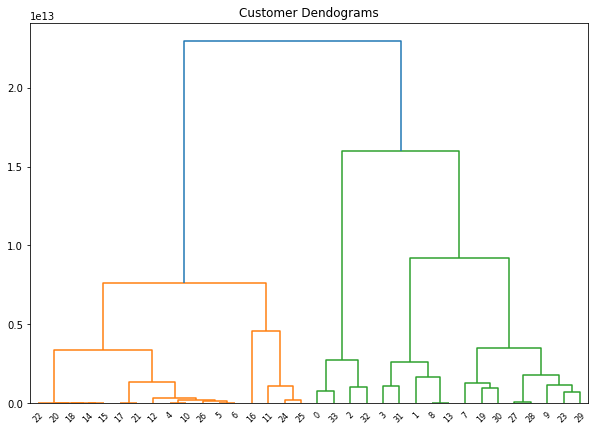

In [9]:
data = get_rdd_matrix(target_G, target_rad, target_measure)
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

### Agglomerative Hierarchical Clustering:

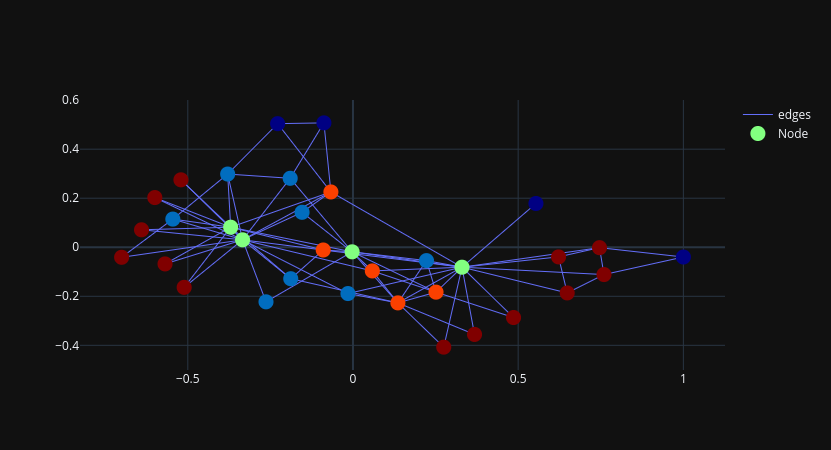

-0.0918803418803419
3.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
%%timeit -n1 -r1
df = other_sims.agglomerative_hierarchical_clustering(target_G,target_rad, measures.global_graph_degree, target_clusters)
fig = visualize.visualize_rdd_agglomerative_hierarchical_clustering(target_G, target_rad, target_measure, pos, target_clusters)
fig.show()
df = df.sort_values('cluster')
# print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

## K-Medoids Clustering

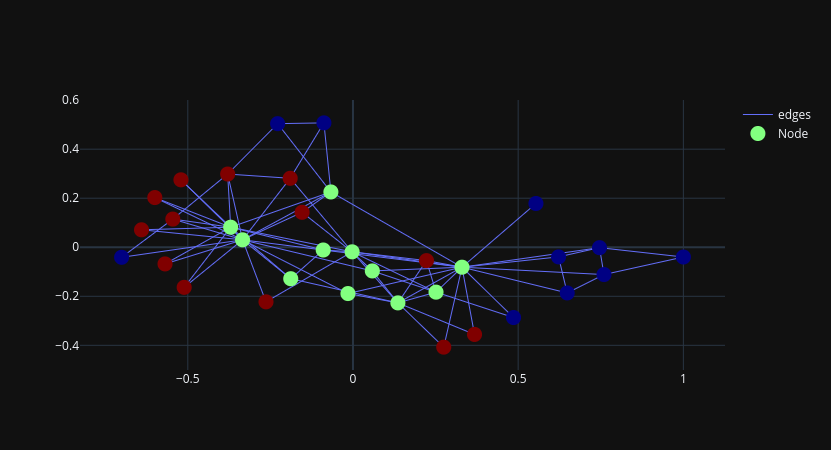

-0.034763313609467515
3.55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
%%timeit -n1 -r1
df = other_sims.kmedoid_clustering2(target_G, RDD.get_rdd_matrix(target_G, target_rad, measures.global_graph_degree), target_clusters)
fig = visualize.visualize_rdd_kmedoid(target_G, target_rad, target_measure, pos, target_clusters)
fig.show()
df = df.sort_values('cluster')
# print(df)1

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

# Modularity

Modularity is the fraction of the edges that fall within the given groups minus the expected fraction if edges were distributed at random. The value of the modularity for unweighted and undirected graphs lies in the range $[-1/2,1][-1/2,1]$. It is positive if the number of edges within groups exceeds the number expected on the basis of chance. For a given division of the network's vertices into some modules, modularity reflects the concentration of edges within modules compared with random distribution of links between all nodes regardless of modules.

https://en.wikipedia.org/wiki/Modularity_(networks)

Here our goal is to test the modularity after clustering based on RDD values and compare that to clustering based on other algorithms, such as ASCOS.

## Max modularity

In [15]:
print("Max modularity:", nx.algorithms.community \
      .modularity(target_G, nx.algorithms.community \
      .modularity_max.greedy_modularity_communities(target_G)))

all_results = pd.DataFrame({'clusters': range(1, 20, 1)})

Max modularity: 0.3806706114398422


# KMedoid clustering Modularity

In [23]:
kmedoid_results = pd.DataFrame()

## RDD

In [30]:
results = []
for k in range(1,10,1):
    rdd_matrix = RDD.get_rdd_matrix(target_G, 3, measures.global_graph_degree)
    rdd_matrix.index += 1
    cluster_data = kmedoid_clustering2(target_G, rdd_matrix, k)
    clusters = df_to_cluster_list(cluster_data)
    result = nx.algorithms.community.modularity(target_G, clusters)
    print(f"Modularity {k} clusters:", result)
    results.append(result)
kmedoid_results['RDD'] = results

Modularity 1 clusters: 0.0
Modularity 2 clusters: -0.01849112426035504
Modularity 3 clusters: -0.032626561472715324
Modularity 4 clusters: -0.051528599605522744
Modularity 5 clusters: -0.04331032215647607
Modularity 6 clusters: -0.04331032215647607
Modularity 7 clusters: -0.04331032215647607
Modularity 8 clusters: -0.04331032215647607
Modularity 9 clusters: -0.04331032215647607


## Final Results

In [31]:
rdd_matrix

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
1,0.000000,16.911789,11.205609,23.222704,42.246509,40.142871,40.142871,30.198134,20.484827,35.783505,...,46.062031,46.506164,45.325546,29.292699,31.396337,35.113089,26.620334,21.768356,8.784798,3.015224
2,16.911789,0.000000,9.495568,6.310915,25.334720,23.231082,23.231082,13.286345,7.945679,18.871716,...,29.150243,29.594375,28.413757,14.004934,16.108572,18.201300,10.791227,7.021932,8.326139,16.095713
3,11.205609,9.495568,0.000000,15.806483,34.830288,32.726650,32.726650,22.781913,9.549889,28.367284,...,38.645810,39.089943,37.909325,21.876478,23.980116,27.696868,19.204113,10.562747,5.368577,12.013556
4,23.222704,6.310915,15.806483,0.000000,19.023805,16.920167,16.920167,6.975430,8.256594,12.560801,...,22.839328,23.283460,22.102842,7.694019,9.797657,11.890385,4.480312,6.597088,14.637054,22.406628
5,42.246509,25.334720,34.830288,19.023805,0.000000,2.103638,2.103638,12.048375,25.280399,8.463004,...,5.707431,6.151563,3.079037,12.953810,10.850172,7.332569,15.626175,25.620893,33.461711,41.231285
6,40.142871,23.231082,32.726650,16.920167,2.103638,0.000000,0.000000,9.944737,23.176761,8.359366,...,7.811069,8.255202,5.182675,10.850172,10.746533,5.228930,13.522537,23.517255,31.358073,39.127647
7,40.142871,23.231082,32.726650,16.920167,2.103638,0.000000,0.000000,9.944737,23.176761,8.359366,...,7.811069,8.255202,5.182675,10.850172,10.746533,5.228930,13.522537,23.517255,31.358073,39.127647
8,30.198134,13.286345,22.781913,6.975430,12.048375,9.944737,9.944737,0.000000,13.232024,10.186771,...,15.863898,16.308030,15.127412,5.319988,7.423626,4.914955,3.577800,13.572518,21.413336,29.182910
9,20.484827,7.945679,9.549889,8.256594,25.280399,23.176761,23.176761,13.232024,0.000000,18.817396,...,29.095922,29.540054,28.359437,12.326589,14.430228,18.146979,9.654224,3.283529,12.440518,21.292774
10,35.783505,18.871716,28.367284,12.560801,8.463004,8.359366,8.359366,10.186771,18.817396,0.000000,...,12.278526,12.722659,9.542041,6.490806,4.387168,11.422931,9.163171,19.157889,26.998707,34.768281


In [32]:
kmedoid_results

,RDD
0,0.000000
1,-0.018491
2,-0.032627
3,-0.051529
4,-0.043310
5,-0.043310
6,-0.043310
7,-0.043310
8,-0.043310
